In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

## Wiener process:
$dX_{t} = \mu(X_{t})\, dt + \sigma(X_{t})\, dW_{t}$

In [2]:
pSet = {
    "sigma": 1.,
    "eta": 2.,
    "lambda": 3.,
}


def mu(x: torch.Tensor) -> torch.Tensor:
    return pSet["sigma"]**2*(pSet["eta"] - 0.5*pSet["lambda"])*torch.pow(x, 2.0*pSet["eta"] - 1.)

def sigma(x: torch.Tensor) -> torch.Tensor:
    return pSet["sigma"]*torch.pow(x, pSet["eta"])

beta = 1 + (pSet["lambda"]-3.) / (2*(pSet["eta"] - 1.))

In [3]:
ensemble_size = 1000
xmin = 1.0
xmax = 1000.0
dt = 1e-3
T = 1e1
x0 = xmin + (xmax - xmin)*torch.rand(1, 1)

In [4]:
no_timepoints = int(T // dt) + 1
xs = torch.zeros(no_timepoints, ensemble_size)
xs[0] = x0[None, :]

for t, _ in enumerate(xs[1:]):
    dW = torch.normal(mean=0.0, std=torch.ones(1, ensemble_size))
    xs[t+1] = xs[t] + mu(xs[t])*dt + sigma(xs[t])*(dt**0.5)*dW
    
    # apply reflecting boundary conditions
    xs[t+1] = (xs[t+1] - xmin) % (xmax-xmin) + xmin

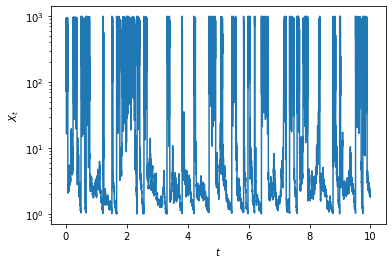

In [5]:
fig, axs = plt.subplots()
axs.semilogy(np.linspace(0.0, T, num=no_timepoints), xs[:, 10].numpy())
axs.set_xlabel(r"$t$")
axs.set_ylabel(r"$X_{t}$")
fig.show()

In [6]:
def stat_auto_corr(x: torch.tensor, no_lags=11) -> torch.tensor:
    """
    calculates the auto_correlation of x
    args:
        x (torch.tensor):   data series tensor
                            size = (no_time_points, no_species)
        
    vals:
        A (torch.tensor):   auto_correlation matrix
    """
    dev = x.device
    dtype = x.dtype
    
    Rxx = torch.zeros((no_lags, x.size(dim=-1)), device=dev, dtype=dtype)
    mean = torch.mean(x, dim=0)
    for lag in torch.arange(0, no_lags, dtype=torch.long):
        x_shifted = torch.roll(x, int(lag), dims=0)
        Rxx[lag] = torch.mean((x[lag:] - mean)*(x_shifted[lag:]-mean), dim=0)
    Rxx /= Rxx.clone()[0]
    return Rxx

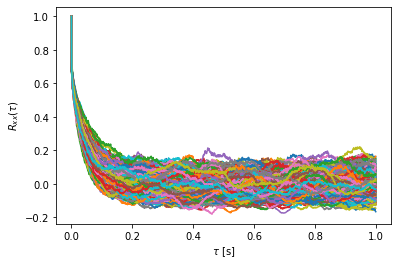

In [17]:
no_lags = 1000
rxx = stat_auto_corr(xs, no_lags=no_lags)

fig, axs = plt.subplots()
axs.plot(np.linspace(0.0, no_lags*dt, num=no_lags), rxx.numpy())
axs.set_xlabel(r"$\tau$ [s]")
axs.set_ylabel(r"$R_{xx}(\tau)$")
fig.show()

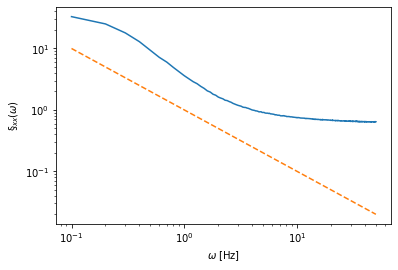

In [23]:
sxx = torch.fft.rfft(rxx.mean(dim=-1))
omega = np.arange(len(sxx))[1:] / T

fig, axs = plt.subplots()
axs.loglog(omega, np.abs(sxx.real.numpy())[1:])
axs.loglog(omega, omega**(-beta), linestyle="dashed")
axs.set_xlabel(r"$\omega$ [Hz]")
axs.set_ylabel(r"$\S_{xx}(\omega)$")
fig.show()